# Using statmodels

<a href="http://statsmodels.sourceforge.net/">Statmodels</a> is a library integrated with pandas that provides a framework for statistical analysis. The module <code>scipy.stats</code> provides also statistica analysis libraries.

Before starting, some imports...

In [1]:
# Overall imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as scipy
import statsmodels.api as sm # statmodels import convention

## Overview of package structure

Statsmodels organizes different models in different modules, e.g. <code>statsmodels.nonparametric</code>. You will need to import some of them for particular types of analysis. 
Some of the models are in <code>statmodels.formulas.api</code> also, that allows for using R-style <a href="https://patsy.readthedocs.org/en/v0.1.0/overview.html">patsy formulas</a>.


In [2]:
import statsmodels.formula.api as smf
dir(smf) # See the contents in the package. 

['GEE',
 'GLM',
 'GLS',
 'GLSAR',
 'Logit',
 'MNLogit',
 'MixedLM',
 'NegativeBinomial',
 'NominalGEE',
 'OLS',
 'OrdinalGEE',
 'PHReg',
 'Poisson',
 'Probit',
 'QuantReg',
 'RLM',
 'WLS',
 '__builtins__',
 '__doc__',
 '__file__',
 '__name__',
 '__package__',
 'gee',
 'glm',
 'gls',
 'glsar',
 'logit',
 'mixedlm',
 'mnlogit',
 'negativebinomial',
 'nominal_gee',
 'ols',
 'ordinal_gee',
 'phreg',
 'poisson',
 'probit',
 'quantreg',
 'rlm',
 'wls']

## Getting started: linear models

In [3]:
from statsmodels.formula.api import ols # ordinary least squares.

Example: Salary data
* Output: S, salary of employees
* Input:
   * X, experience in years
   * M, mangement experience (0/1, no/yes)
   * E, educational level (1/2/3 = bachelor/master/phd)

In [4]:
# From Standford's Stats 191 course:
url = "http://web.stanford.edu/class/stats191/data/salary.table"
df = pd.read_table(url)
df.head(3)

,S,X,E,M
0,13876,1,1,1
1,11608,1,3,0
2,18701,1,3,1


We can check that it seems that people with management experience earn more.

In [6]:
by_mng = df.groupby("M")
by_mng["S"].mean()

M
0    14285.307692
1    21150.550000
Name: S, dtype: float64

But the same happens with people with higher education levels, less clearly, as there seems not to be a clear difference for PhD.

In [7]:
df.groupby("E").mean()

,S,X,M
E,,,
1,14941.500000,8.142857,0.357143
2,18286.368421,8.368421,0.368421
3,18292.846154,5.538462,0.615385


These are only a couple of observations that we can get from exploring data. Now, let's try to find a linear model. 

In [8]:
# This is patsy formula syntax.
formula = "S ~ C(E) + C(M) + X"  # C(xx) means treat as categorical & create dummy variables.
model = ols(formula, df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      S   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     226.8
Date:                Fri, 08 May 2015   Prob (F-statistic):           2.23e-27
Time:                        15:26:59   Log-Likelihood:                -381.63
No. Observations:                  46   AIC:                             773.3
Df Residuals:                      41   BIC:                             782.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   8035.5976    386.689     20.781      0.000      7254.663  8816.532
C(E)[T.2]   3144.0352    361.968      8.686      0.000      2413.025  3875.045
C(E)[T.3]   2996.2103    411.753      7.277      0.000      2164.659  3827.762
C(M)[T.1]   6883.5310    313.919     21.928      0.000      6249.559  7517.503
X            546.1840     30.519     17.896      0.000       484.549   607.819
==============================================================================
Omnibus:                        2.293   Durbin-Watson:                   2.237
Prob(Omnibus):                  0.318   Jarque-Bera (JB):                1.362
Skew:                          -0.077   Prob(JB):                        0.506
Kurtosis:                       2.171   Cond. No.                         33.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

And now you can use the model as predictor.

In [17]:
salary = model.predict({'X':[5], 'M':[0], 'E':[2]})
print salary

[ 13910.55293412]


## Outlier detection

In [18]:
outliers = model.outlier_test()
print len(outliers)
outliers.sort("unadj_p", inplace=True, ascending=False)
outliers.max() # P-values are far from zero, so no outliers evident.

46


student_resid    1.838014
unadj_p          0.988292
bonf(p)          1.000000
dtype: float64

## Is the model good enough?

If we check the residuals we get the following.

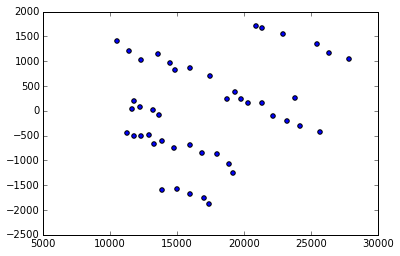

In [11]:
plt.scatter(df["S"], model.resid)

It seems residuals do not follow a completely random pattern, which suggests some model may provide a better fit.

Now we plot residuals by groups.

1 0
1 1
2 0
2 1
3 0
3 1


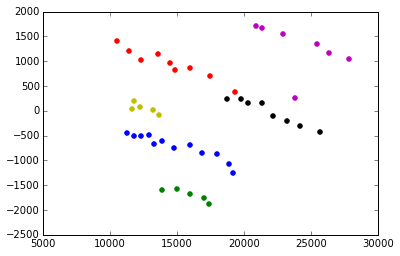

In [12]:
df["resid"] = model.resid
by_factor = df.groupby(["E", "M"])
colors = ['r', 'g', 'b', 'm', 'y', 'k']
i =0
for values, group in by_factor:
    e, m = values
    print e,m
    plt.scatter(group["S"], group["resid"], color = colors[i])
    i+=1
    

## Testing interaction

We can test interaction by creating a new model, then using ANOVA.

You can test there is an interarction between experience in years and level of education or for example, that there is an interaction between education level and management level. 

In [13]:


intermodel_1 = ols('S ~ C(E)*X + C(M)', df).fit()

intermodel_2 = ols('S ~ X + C(E)*C(M)', df).fit()

# Are the fit of the new terms of the regression significant? 
intermodel_1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      S   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     158.6
Date:                Fri, 08 May 2015   Prob (F-statistic):           8.23e-26
Time:                        15:27:19   Log-Likelihood:                -379.47
No. Observations:                  46   AIC:                             772.9
Df Residuals:                      39   BIC:                             785.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    7256.2800    549.494     13.205      0.000      6144.824  8367.736
C(E)[T.2]    4172.5045    674.966      6.182      0.000      2807.256  5537.753
C(E)[T.3]    3946.3649    686.693      5.747      0.000      2557.396  5335.333
C(M)[T.1]    7102.4539    333.442     21.300      0.000      6428.005  7776.903
X             632.2878     53.185     11.888      0.000       524.710   739.865
C(E)[T.2]:X  -125.5147     69.863     -1.797      0.080      -266.826    15.796
C(E)[T.3]:X  -141.2741     89.281     -1.582      0.122      -321.861    39.313
==============================================================================
Omnibus:                        0.432   Durbin-Watson:                   2.179
Prob(Omnibus):                  0.806   Jarque-Bera (JB):                0.590
Skew:                           0.144   Prob(JB):                        0.744
Kurtosis:                       2.526   Cond. No.                         69.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
# This seems to be a better fitted model:
intermodel_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      S   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     5517.
Date:                Fri, 08 May 2015   Prob (F-statistic):           1.67e-55
Time:                        15:27:23   Log-Likelihood:                -298.74
No. Observations:                  46   AIC:                             611.5
Df Residuals:                      39   BIC:                             624.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept            9472.6854     80.344    117.902      0.000      9310.175  9635.196
C(E)[T.2]            1381.6706     77.319     17.870      0.000      1225.279  1538.063
C(E)[T.3]            1730.7483    105.334     16.431      0.000      1517.690  1943.806
C(M)[T.1]            3981.3769    101.175     39.351      0.000      3776.732  4186.022
C(E)[T.2]:C(M)[T.1]  4902.5231    131.359     37.322      0.000      4636.825  5168.222
C(E)[T.3]:C(M)[T.1]  3066.0351    149.330     20.532      0.000      2763.986  3368.084
X                     496.9870      5.566     89.283      0.000       485.728   508.246
==============================================================================
Omnibus:                       74.761   Durbin-Watson:                   2.244
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1037.873
Skew:                          -4.103   Prob(JB):                    4.25e-226
Kurtosis:                      24.776   Cond. No.                         79.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

What does ANOVA say?

In [15]:
from statsmodels.stats.anova import anova_lm

t1 = anova_lm(model, intermodel_1)

t2 = anova_lm(model, intermodel_2)

In [20]:
anova_lm?

In [16]:
# High p-value, not significant differences with the original model:
print t1
print "------"
# Low p-value, significant differences with the original model:
print t2

   df_resid              ssr  df_diff         ss_diff         F    Pr(>F)
0        41  43280719.492876        0             NaN       NaN       NaN
1        39  39410679.807560        2  3870039.685316  1.914856  0.160964
------
   df_resid              ssr  df_diff          ss_diff           F  \
0        41  43280719.492876        0              NaN         NaN   
1        39   1178167.864864        2  42102551.628012  696.844466   

         Pr(>F)  
0           NaN  
1  3.025504e-31  


The difference between Master's and PhD in the management group is different than in the non-management group. This is an interaction between the two qualitative variables management,M and education,E.

## More on the example!

Go to: http://web.stanford.edu/class/stats191/
        
And check the "Interactions and qualitatitve variables".